# AN2DL Challenge 2 — Path Foundation + PyTorch Head

## Versione v4 - Immagini Originali + Filtro Testato 🔬

**Path:** Immagini ORIGINALI (sfondo grigio vetrino)

**Filtro:** Funzioni testate che funzionano correttamente (tissue vs background vs ink)

In [1]:
!pip -q install lion-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [2]:
import os
os.environ["TF_CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
print("TF on CPU")

TF on CPU


In [3]:
import gc, math, random, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False; torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(f"Device: {device} | GPUs: {n_gpu}")
def cleanup_memory(): gc.collect(); torch.cuda.is_available() and torch.cuda.empty_cache()

Device: cuda | GPUs: 2


In [4]:
# CONFIG - IMMAGINI ORIGINALI
import os
BASE_PATH = "/kaggle/input/kagglejson/an2dl_challenge2_original/an2dl_challenge2_original"
TRAIN_LABELS_PATH = f"{BASE_PATH}/train/train_labels.csv"
TRAIN_IMAGES_ROOT = f"{BASE_PATH}/train/images"
TEST_IMAGES_ROOT = f"{BASE_PATH}/test/images"

WORKDIR = "/kaggle/working"
SUBMISSION_PATH = f"{WORKDIR}/submission.csv"
CKPT_PATH = f"{WORKDIR}/best_head.pth"
SWA_CKPT_PATH = f"{WORKDIR}/swa_head.pth"
TRAIN_EMB_PATH = f"{WORKDIR}/train_emb_v4.npz"
VAL_EMB_PATH = f"{WORKDIR}/val_emb_v4.npz"
TEST_EMB_PATH = f"{WORKDIR}/test_emb_v4.npz"

MODEL_NAME = "google/path-foundation"
IMG_SIZE, PATCH_SIZE, PATCH_STRIDE = 224, 224, 112
DROP_LAST_PATCH = False
USE_BLACK_FILTER = True
TOPK_IF_TOO_MANY = 24
FORCE_AT_LEAST_ONE_PATCH = True
BATCH_SIZE_HEAD = 2048 if n_gpu >= 2 else 1024
NUM_WORKERS, TF_BATCH = 4, 64
PIN_MEMORY = torch.cuda.is_available()

print(f"✓ Train: {TRAIN_IMAGES_ROOT}")
print(f"✓ Test:  {TEST_IMAGES_ROOT}")

✓ Train: /kaggle/input/kagglejson/an2dl_challenge2_original/an2dl_challenge2_original/train/images
✓ Test:  /kaggle/input/kagglejson/an2dl_challenge2_original/an2dl_challenge2_original/test/images


In [6]:
import tensorflow as tf
from huggingface_hub import login, from_pretrained_keras
try: tf.config.set_visible_devices([], "GPU")
except: pass
print("TF devices:", tf.config.list_physical_devices())
login(new_session=False)
path_model = from_pretrained_keras(MODEL_NAME)
EMB_DIM = int(path_model(tf.zeros([1,IMG_SIZE,IMG_SIZE,3])).shape[-1])
print(f"EMB_DIM = {EMB_DIM}")

TF devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

fingerprint.pb:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

variables/variables.data-00000-of-00001:   0%|          | 0.00/110M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Test.png:   0%|          | 0.00/208k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/3.64k [00:00<?, ?B/s]

I0000 00:00:1765897430.957907     149 service.cc:148] XLA service 0x78f6cc00d3e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765897430.958697     149 service.cc:156]   StreamExecutor device (0): Host, Default Version


EMB_DIM = 384


I0000 00:00:1765897432.632164     149 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
df = pd.read_csv(TRAIN_LABELS_PATH)
IMG_COL, LABEL_COL = df.columns[0], df.columns[1]
unique_labels = sorted(df[LABEL_COL].unique())
label2id = {l:i for i,l in enumerate(unique_labels)}
id2label = {v:k for k,v in label2id.items()}
df["label_id"] = df[LABEL_COL].map(label2id).astype(int)
LABEL_COL_NUM = "label_id"
NUM_CLASSES = len(unique_labels)
print(f"Classes: {NUM_CLASSES} | {unique_labels}")
print(df[LABEL_COL].value_counts())

Classes: 4 | ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']
label
Luminal B          220
Luminal A          205
HER2(+)            189
Triple negative     77
Name: count, dtype: int64


In [ ]:
# ============================================================
# CELL 5 - PATCH UTILS + BLACK FILTER (TESTED FUNCTIONS)
# ============================================================
import cv2

def pad_reflect_to_size(img_np: np.ndarray, target_h: int, target_w: int) -> np.ndarray:
    h, w, _ = img_np.shape
    pad_bottom = max(0, target_h - h)
    pad_right  = max(0, target_w - w)
    if pad_bottom == 0 and pad_right == 0:
        return img_np
    return cv2.copyMakeBorder(img_np, 0, pad_bottom, 0, pad_right, borderType=cv2.BORDER_REFLECT_101)

def compute_grid(H, W, patch_size, stride, drop_last_patch):
    if drop_last_patch:
        xs = list(range(0, W - patch_size + 1, stride)) if W >= patch_size else []
        ys = list(range(0, H - patch_size + 1, stride)) if H >= patch_size else []
    else:
        n_cols = max(1, math.ceil((W - patch_size) / stride) + 1) if W > patch_size else 1
        n_rows = max(1, math.ceil((H - patch_size) / stride) + 1) if H > patch_size else 1
        xs = [min(k * stride, max(0, W - patch_size)) for k in range(n_cols)]
        ys = [min(k * stride, max(0, H - patch_size)) for k in range(n_rows)]
    return xs, ys

TISSUE_DOWNSAMPLE = 96

# --- tissue vs background (HSV heuristics) ---
TISSUE_S_THR = 20
TISSUE_V_MAX = 245
BG_S_MAX = 10
BG_V_MIN = 245

# --- pen/ink artifacts (dark + saturated) ---
INK_V_MAX = 90
INK_S_MIN = 25

# main thresholds
MIN_TISSUE_FRAC = 0.010
MAX_INK_FRAC = 0.250

def _hsv_small(patch_np):
    hsv = cv2.cvtColor(patch_np, cv2.COLOR_RGB2HSV)
    if hsv.shape[0] != TISSUE_DOWNSAMPLE or hsv.shape[1] != TISSUE_DOWNSAMPLE:
        hsv = cv2.resize(hsv, (TISSUE_DOWNSAMPLE, TISSUE_DOWNSAMPLE), interpolation=cv2.INTER_AREA)
    return hsv

def _tissue_ink_bg_frac(patch_np: np.ndarray):
    hsv = _hsv_small(patch_np)
    S = hsv[:, :, 1]
    V = hsv[:, :, 2]
    tissue = (S > TISSUE_S_THR) & (V < TISSUE_V_MAX)
    ink = (V < INK_V_MAX) & (S > INK_S_MIN)
    bg = (S < BG_S_MAX) & (V > BG_V_MIN)
    return float(tissue.mean()), float(ink.mean()), float(bg.mean())

def is_black_patch(patch_np: np.ndarray) -> bool:
    tissue_frac, ink_frac, bg_frac = _tissue_ink_bg_frac(patch_np)
    if tissue_frac < MIN_TISSUE_FRAC:
        return True
    if (ink_frac > MAX_INK_FRAC) and (tissue_frac < 0.25):
        return True
    if (bg_frac > 0.98) and (tissue_frac < 0.03):
        return True
    return False

def patch_black_score(patch_np: np.ndarray) -> float:
    tissue_frac, ink_frac, bg_frac = _tissue_ink_bg_frac(patch_np)
    score = tissue_frac - 0.60 * ink_frac + 0.05 * (1.0 - bg_frac)
    return float(score)

print("✓ Patch filter configured (tissue vs background vs ink)")

✓ Filtro patch configurato (tissue vs background vs ink)


In [ ]:
# ============================================================
# CELL 6 - BUILD PATCH COORDS PER IMAGE
# ============================================================
def build_patch_index(df_in, img_root, img_col,
                      patch_size=224, stride=224, drop_last_patch=False,
                      use_black_filter=True, topk=12, force_one=True):
    df_in = df_in.reset_index(drop=True)
    valid_rows, coords = [], []
    total_candidates, dropped_black, forced_imgs = 0, 0, 0

    for i in range(len(df_in)):
        img_name = str(df_in.iloc[i][img_col])
        img_path = os.path.join(img_root, img_name)
        if not os.path.isfile(img_path): continue
        try: img_np = np.array(Image.open(img_path).convert("RGB"))
        except: continue

        H, W = img_np.shape[:2]
        xs, ys = compute_grid(H, W, patch_size, stride, drop_last_patch)
        cand, all_cand = [], []

        for y in ys:
            for x in xs:
                total_candidates += 1
                patch = img_np[y:y+patch_size, x:x+patch_size, :]
                if not drop_last_patch:
                    patch = pad_reflect_to_size(patch, patch_size, patch_size)
                score = patch_black_score(patch)
                all_cand.append((score, x, y))
                if use_black_filter and is_black_patch(patch):
                    dropped_black += 1
                    continue
                cand.append((score, x, y))

        if len(cand) == 0 and force_one and len(all_cand) > 0:
            all_cand.sort(key=lambda t: t[0], reverse=True)
            cand = [all_cand[0]]
            forced_imgs += 1

        if len(cand) == 0: continue

        cand.sort(key=lambda t: t[0], reverse=True)
        if topk is not None and len(cand) > topk:
            cand = cand[:topk]

        valid_rows.append(df_in.iloc[i])
        img_id_new = len(valid_rows) - 1
        for _, x, y in cand:
            coords.append((img_id_new, x, y))

    df_out = pd.DataFrame(valid_rows).reset_index(drop=True)
    print(f"[build_patch_index] images: {len(df_out)} | patches kept: {len(coords)}")
    if total_candidates > 0:
        print(f"[build_patch_index] dropped: {dropped_black}/{total_candidates} ({dropped_black/total_candidates:.1%})")
    if forced_imgs > 0:
        print(f"[build_patch_index] forced 1 patch for {forced_imgs} images")
    return df_out, coords

In [ ]:
# SPLIT
train_df, val_df = train_test_split(df, stratify=df[LABEL_COL_NUM], test_size=0.20, random_state=SEED)
print(f"Train: {len(train_df)} | Val: {len(val_df)}")

Train: 552 | Val: 139


In [ ]:
# BUILD PATCH INDEX
train_df2, train_coords = build_patch_index(
    train_df, TRAIN_IMAGES_ROOT, IMG_COL,
    patch_size=PATCH_SIZE, stride=PATCH_STRIDE, drop_last_patch=DROP_LAST_PATCH,
    use_black_filter=USE_BLACK_FILTER, topk=TOPK_IF_TOO_MANY, force_one=FORCE_AT_LEAST_ONE_PATCH
)
val_df2, val_coords = build_patch_index(
    val_df, TRAIN_IMAGES_ROOT, IMG_COL,
    patch_size=PATCH_SIZE, stride=PATCH_STRIDE, drop_last_patch=DROP_LAST_PATCH,
    use_black_filter=USE_BLACK_FILTER, topk=TOPK_IF_TOO_MANY, force_one=FORCE_AT_LEAST_ONE_PATCH
)
num_train_images, num_val_images = len(train_df2), len(val_df2)

[build_patch_index] images: 469 | patches kept: 11234
[build_patch_index] dropped: 28725/56016 (51.3%)
[build_patch_index] images: 112 | patches kept: 2684
[build_patch_index] dropped: 6994/13392 (52.2%)


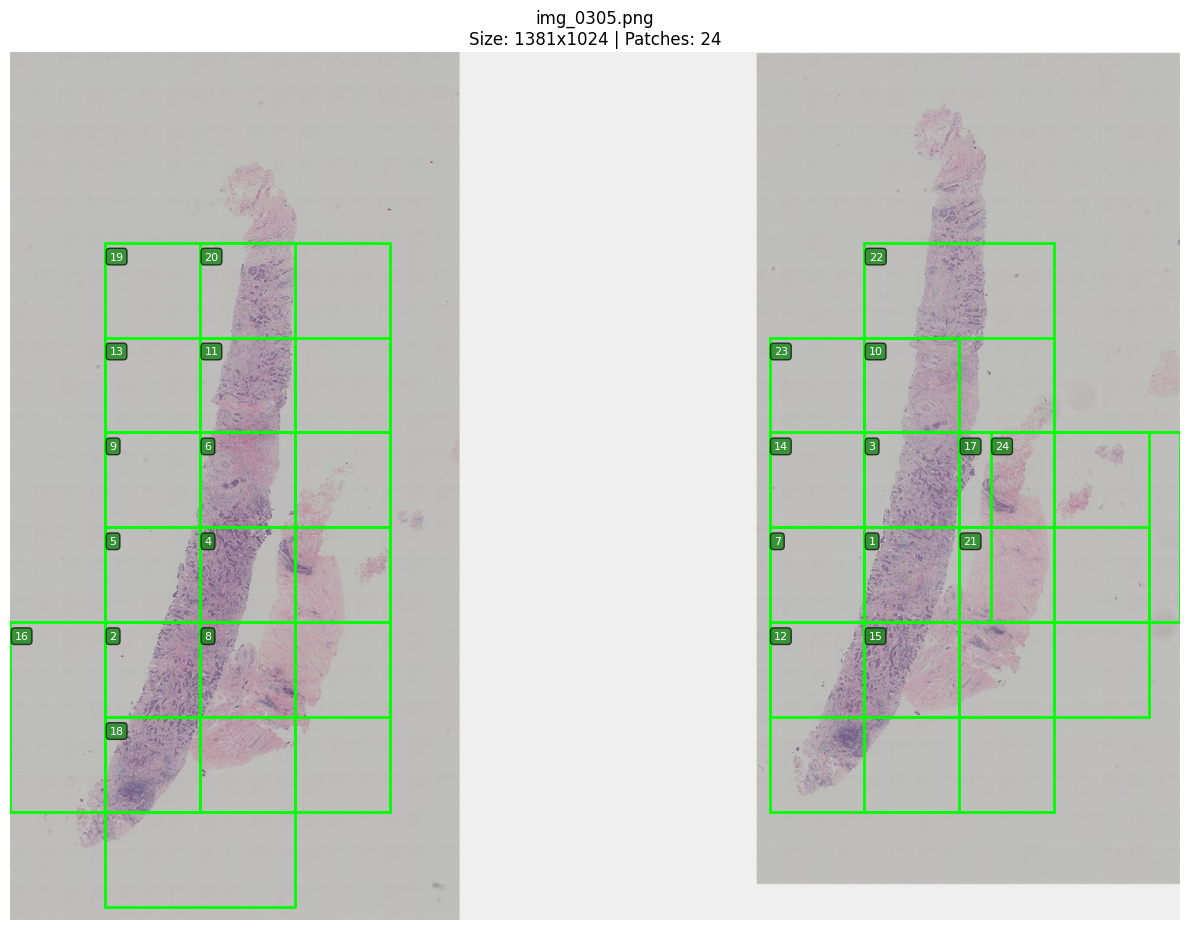

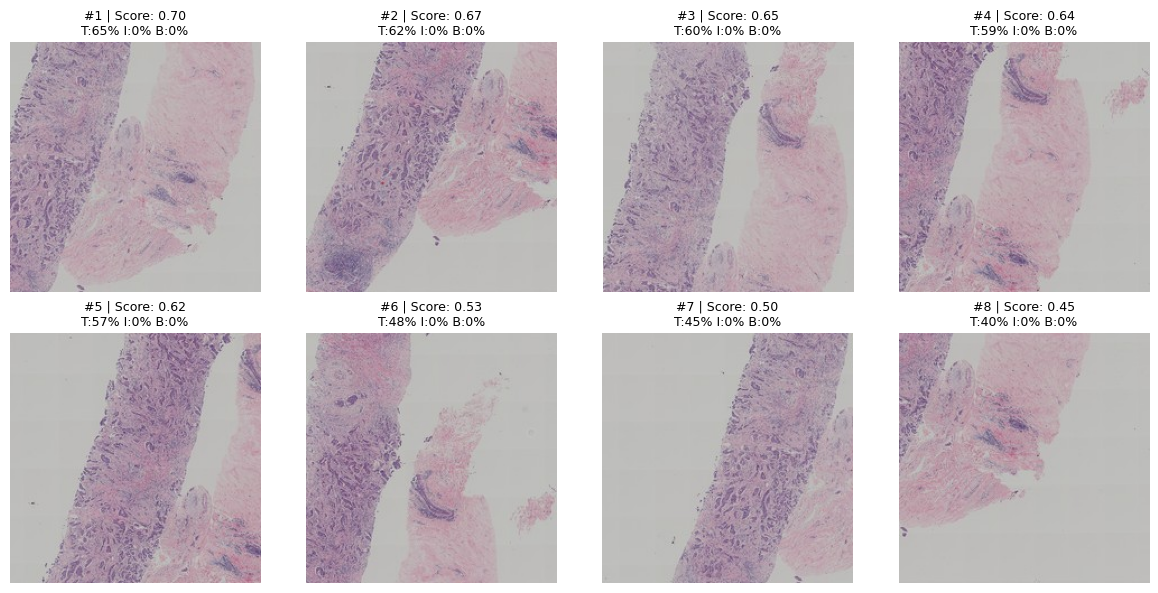

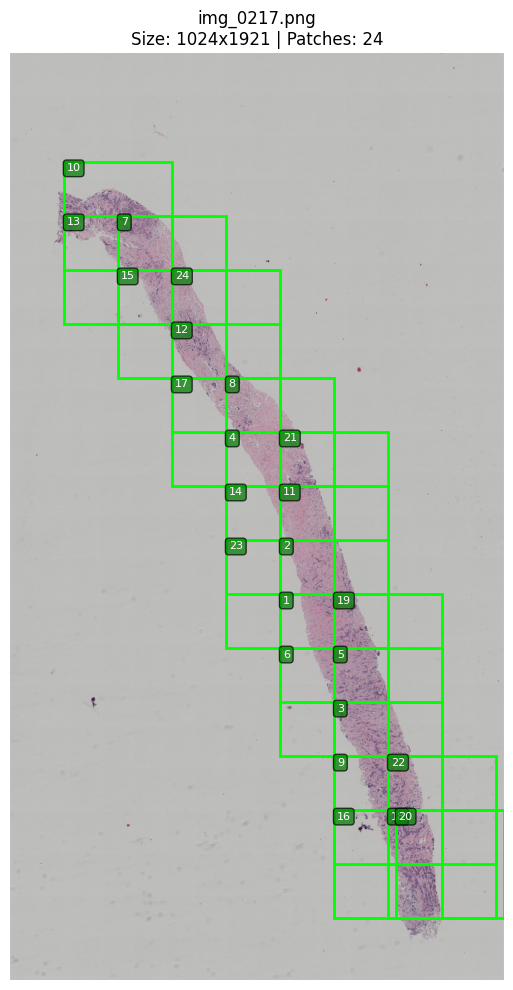

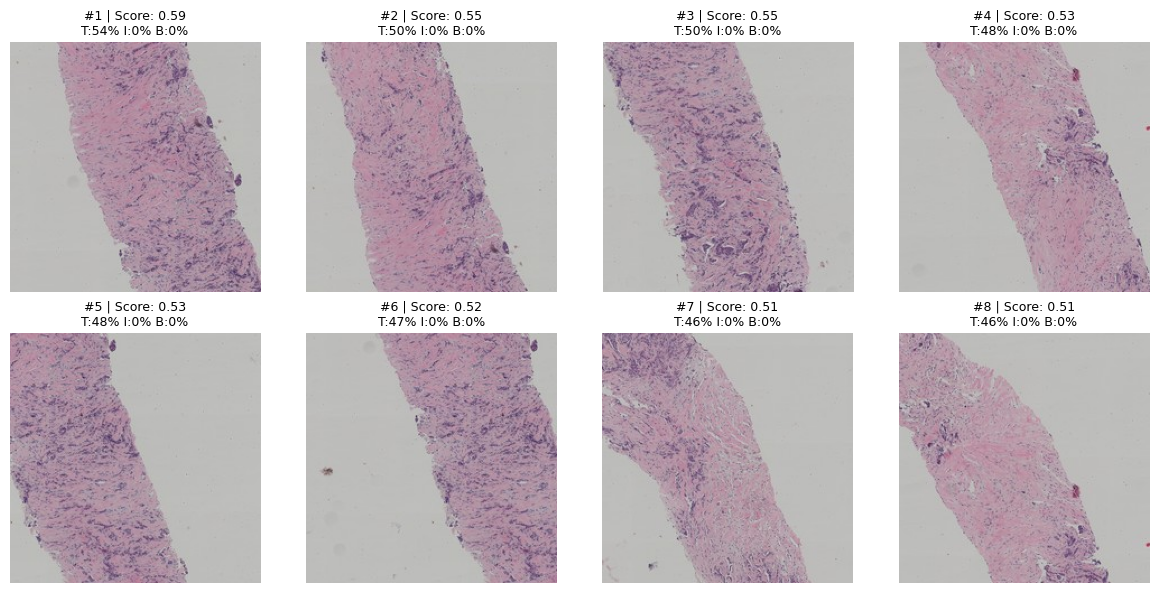

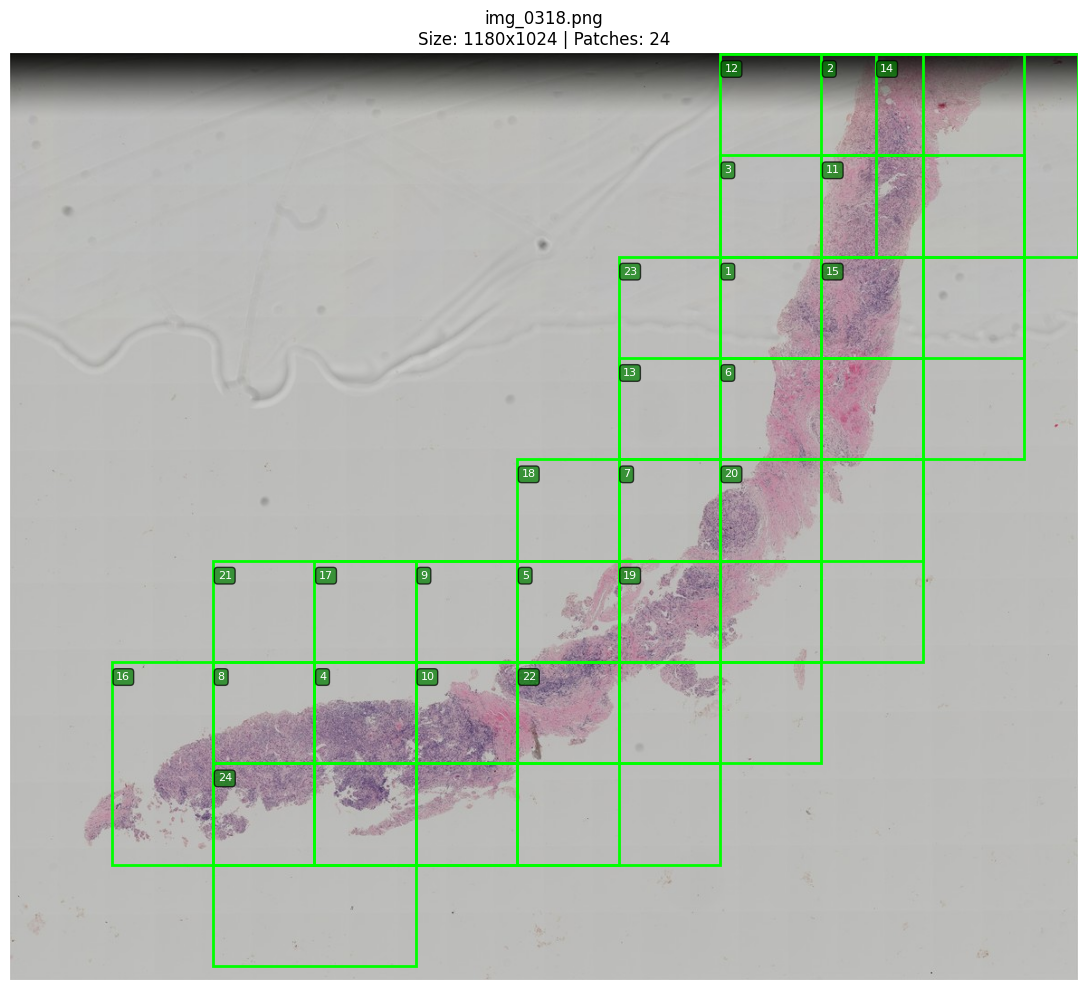

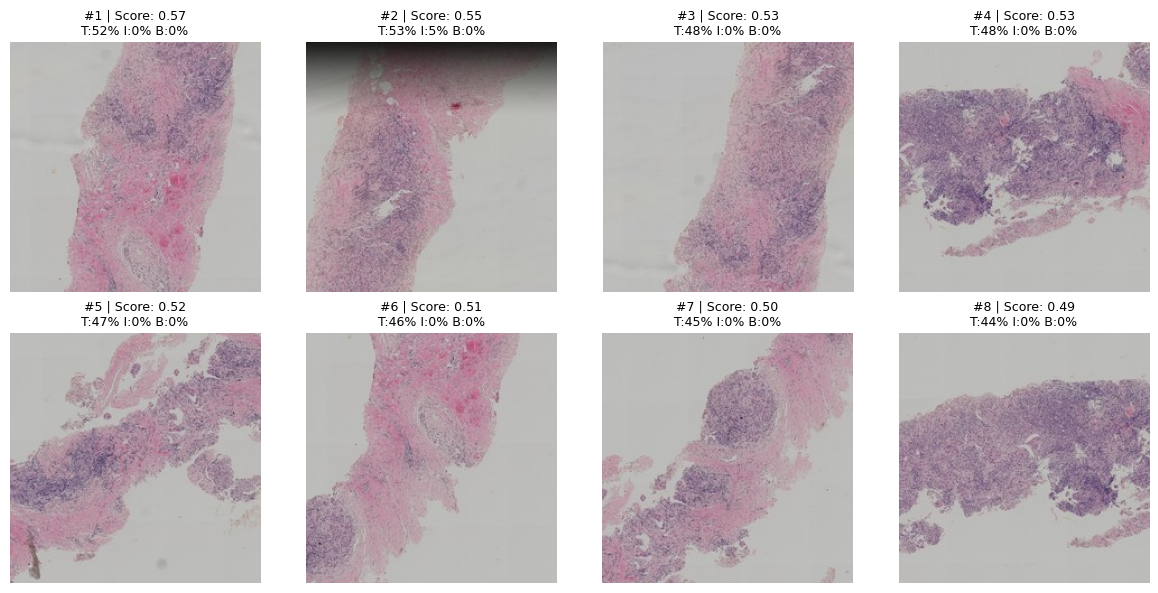

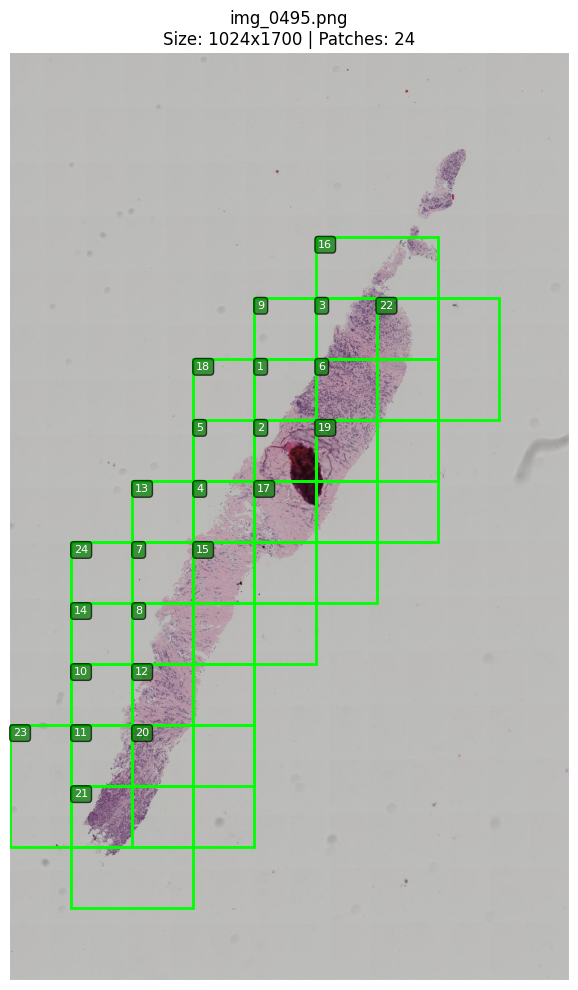

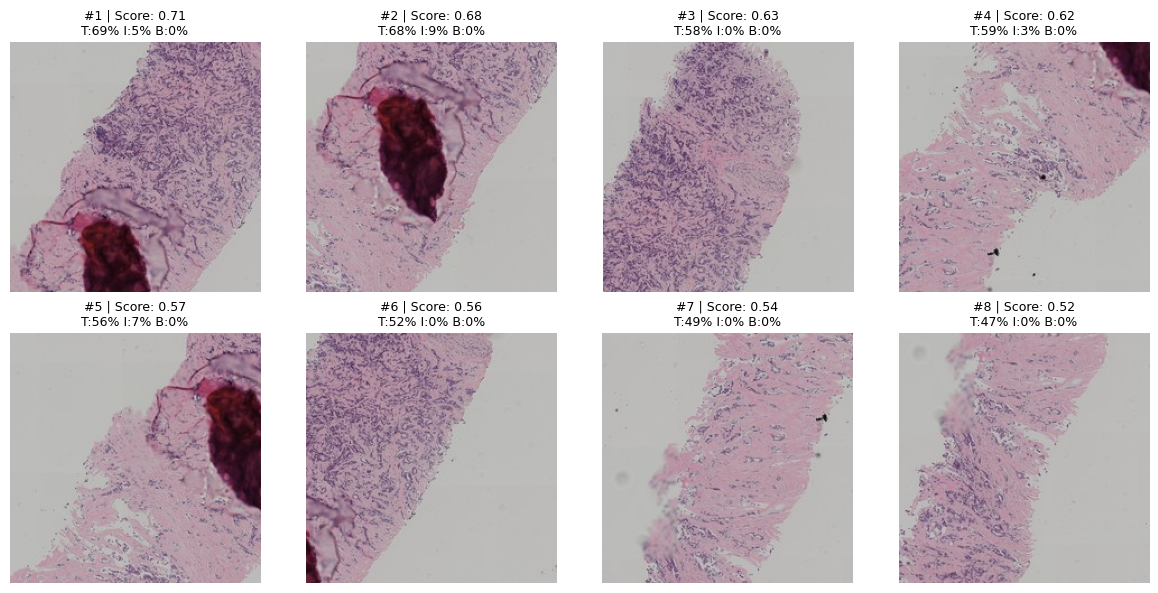

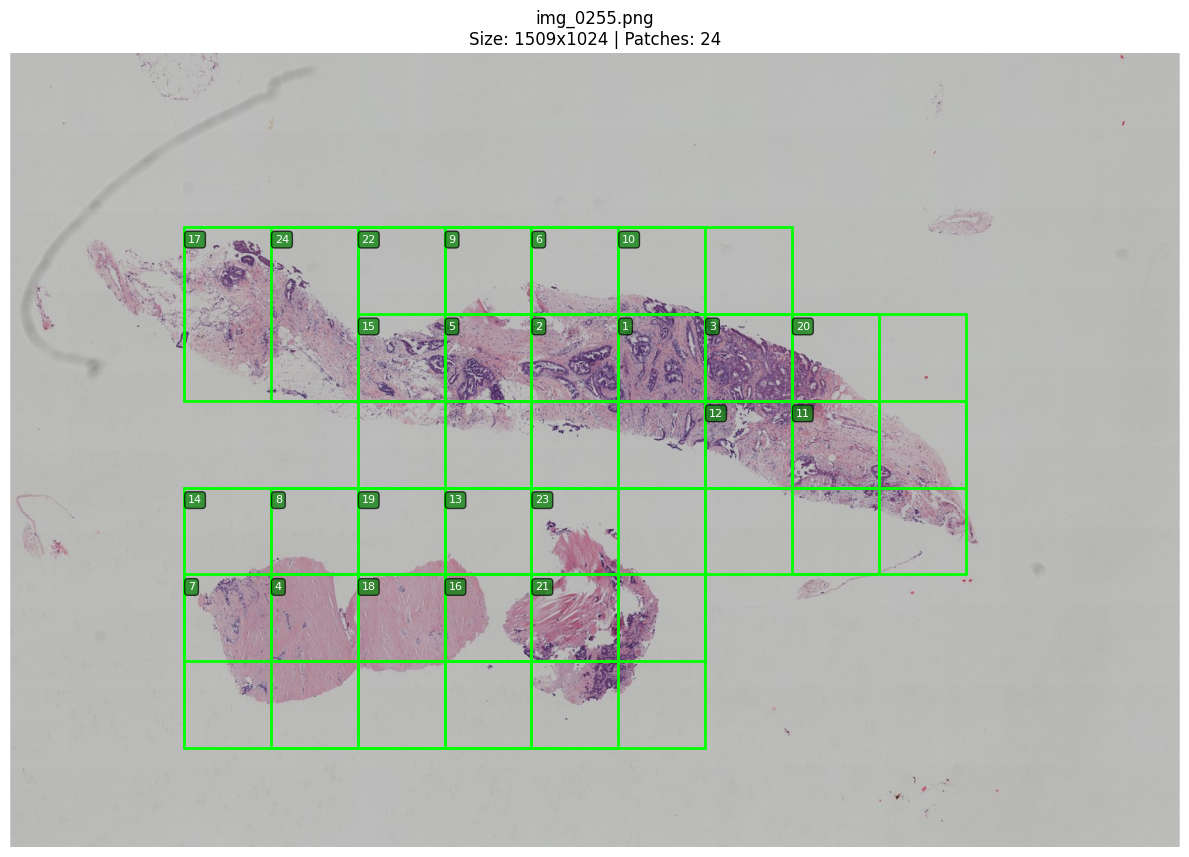

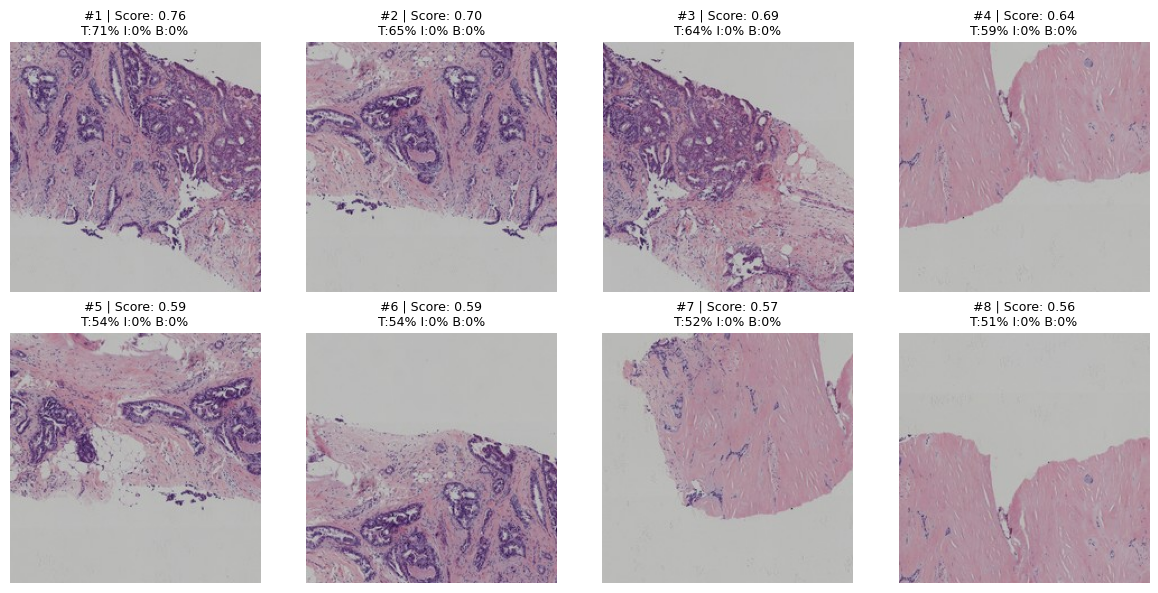

In [ ]:
# ============================================================
# VISUALIZE SELECTED PATCHES (to verify functionality)
# ============================================================
import matplotlib.patches as mpatches

n_show_images = 5
indices = random.sample(range(len(train_df2)), min(n_show_images, len(train_df2)))

for debug_idx in indices:
    img_name = str(train_df2.iloc[debug_idx][IMG_COL])
    img_path = os.path.join(TRAIN_IMAGES_ROOT, img_name)
    img_np = np.array(Image.open(img_path).convert("RGB"))
    kept_patches = [(x, y) for (img_id, x, y) in train_coords if img_id == debug_idx]
    n_patches = len(kept_patches)
    
    # Figure 1: Full image with boxes
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.imshow(img_np)
    ax.set_title(f"{img_name}\nSize: {img_np.shape[1]}x{img_np.shape[0]} | Patches: {n_patches}", fontsize=12)
    
    for i, (x, y) in enumerate(kept_patches):
        rect = mpatches.Rectangle((x, y), PATCH_SIZE, PATCH_SIZE, lw=2, ec='lime', fc='none')
        ax.add_patch(rect)
        ax.text(x+5, y+20, str(i+1), color='white', fontsize=8, bbox=dict(boxstyle='round', fc='green', alpha=0.7))
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Patch grid with score
    if n_patches > 0:
        n_show = min(8, n_patches)
        n_cols = min(4, n_show)
        n_rows = (n_show + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
        axes = np.array(axes).flatten() if n_show > 1 else [axes]
        
        for i, (x, y) in enumerate(kept_patches[:n_show]):
            patch = img_np[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :]
            if patch.shape[0] < PATCH_SIZE or patch.shape[1] < PATCH_SIZE:
                patch = pad_reflect_to_size(patch, PATCH_SIZE, PATCH_SIZE)
            
            score = patch_black_score(patch)
            tissue_frac, ink_frac, bg_frac = _tissue_ink_bg_frac(patch)
            
            axes[i].imshow(patch)
            axes[i].set_title(f"#{i+1} | Score: {score:.2f}\nT:{tissue_frac:.0%} I:{ink_frac:.0%} B:{bg_frac:.0%}", fontsize=9)
            axes[i].axis('off')
        
        # Hide empty axes
        for i in range(n_show, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    print("="*60)

In [ ]:
# EXTRACT EMBEDDINGS
def _to_input(p): return p.astype(np.float32)/255.0

@tf.function(reduce_retracing=True)
def tf_forward(b): return path_model(b, training=False)

def extract_and_cache(df_in, coords, img_root, out_path, has_labels):
    feats, labels, imgids = [], [], []
    fnames = df_in[IMG_COL].astype(str).tolist()
    from tqdm.auto import tqdm
    
    by_img = [[] for _ in range(len(df_in))]
    for (i, x, y) in coords: by_img[i].append((x, y))
    
    for i in tqdm(range(len(df_in)), desc=f"Extract -> {os.path.basename(out_path)}"):
        img = np.array(Image.open(os.path.join(img_root, fnames[i])).convert("RGB"))
        patches = []
        for (x, y) in by_img[i]:
            p = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            if not DROP_LAST_PATCH: p = pad_reflect_to_size(p, PATCH_SIZE, PATCH_SIZE)
            patches.append(_to_input(p))
        if not patches: continue
        
        for s in range(0, len(patches), TF_BATCH):
            batch = np.stack(patches[s:s+TF_BATCH])
            emb = tf_forward(tf.convert_to_tensor(batch)).numpy()
            feats.append(emb.astype(np.float16))
            imgids.append(np.full(len(emb), i, dtype=np.int64))
            if has_labels: labels.append(np.full(len(emb), df_in.iloc[i][LABEL_COL_NUM], dtype=np.int64))
        cleanup_memory()
    
    f = np.concatenate(feats) if feats else np.zeros((0, EMB_DIM), np.float16)
    ids = np.concatenate(imgids) if imgids else np.zeros(0, np.int64)
    if has_labels:
        l = np.concatenate(labels) if labels else np.zeros(0, np.int64)
        np.savez_compressed(out_path, feats=f, labels=l, img_ids=ids, filenames=np.array(fnames, dtype=object))
    else:
        np.savez_compressed(out_path, feats=f, img_ids=ids, filenames=np.array(fnames, dtype=object))
    print(f"Saved: {out_path} | {f.shape}")

if not os.path.isfile(TRAIN_EMB_PATH):
    extract_and_cache(train_df2, train_coords, TRAIN_IMAGES_ROOT, TRAIN_EMB_PATH, True)
else:
    print("Cached:", TRAIN_EMB_PATH)

if not os.path.isfile(VAL_EMB_PATH):
    extract_and_cache(val_df2, val_coords, TRAIN_IMAGES_ROOT, VAL_EMB_PATH, True)
else:
    print("Cached:", VAL_EMB_PATH)

Extract -> train_emb_v4.npz:   0%|          | 0/469 [00:00<?, ?it/s]

Saved: /kaggle/working/train_emb_v4.npz | (11234, 384)


Extract -> val_emb_v4.npz:   0%|          | 0/112 [00:00<?, ?it/s]

Saved: /kaggle/working/val_emb_v4.npz | (2684, 384)


In [ ]:
# LOAD EMBEDDINGS
train_npz, val_npz = np.load(TRAIN_EMB_PATH, allow_pickle=True), np.load(VAL_EMB_PATH, allow_pickle=True)
X_train, y_train, id_train = train_npz["feats"].astype(np.float32), train_npz["labels"].astype(np.int64), train_npz["img_ids"].astype(np.int64)
X_val, y_val, id_val = val_npz["feats"].astype(np.float32), val_npz["labels"].astype(np.int64), val_npz["img_ids"].astype(np.int64)
print(f"Train: {X_train.shape} | Val: {X_val.shape}")

class EmbDS(Dataset):
    def __init__(self, X, y, ids):
        self.X, self.y, self.ids = torch.from_numpy(X), torch.from_numpy(y) if y is not None else None, torch.from_numpy(ids)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return (self.X[i], self.ids[i]) if self.y is None else (self.X[i], self.y[i], self.ids[i])

train_ds, val_ds = EmbDS(X_train, y_train, id_train), EmbDS(X_val, y_val, id_val)

Train: (11234, 384) | Val: (2684, 384)


In [ ]:
# ==================================================================================
# COMPLETE CELL: MIL DATASET + GATED ATTENTION MODEL + TRAINING LOOP
# ==================================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import f1_score
from torch.optim.swa_utils import AveragedModel, SWALR
from tqdm.auto import tqdm

# ------------------------------------------------------------------
# 1. DATA PREPARATION (FROM FLAT PATCHES TO IMAGE BAGS)
# ------------------------------------------------------------------
print("--- Grouping patches into Bags (Images) ---")

def create_bags(X, y, ids, num_imgs):
    bags = [[] for _ in range(num_imgs)]
    bag_labels = {}
    
    # Group features by image ID
    # X, y, ids are aligned numpy arrays
    for i in range(len(X)):
        img_idx = ids[i]
        bags[img_idx].append(X[i])
        # The label is identical for all patches of the same image
        if y is not None:
            bag_labels[img_idx] = y[i]
        
    # Create final clean lists
    final_bags = []
    final_labels = []
    valid_ids = []
    
    for i in range(num_imgs):
        if len(bags[i]) > 0:
            # Stack patches: becomes an array (N_patches, Emb_Dim)
            final_bags.append(np.stack(bags[i]))
            if y is not None:
                final_labels.append(bag_labels[i])
            valid_ids.append(i)
            
    return final_bags, np.array(final_labels) if y is not None else None, np.array(valid_ids)

# Create MIL dataset
train_bags, train_lbls, train_bag_ids = create_bags(X_train, y_train, id_train, num_train_images)
val_bags, val_lbls, val_bag_ids = create_bags(X_val, y_val, id_val, num_val_images)

print(f"Train Bags: {len(train_bags)} | Val Bags: {len(val_bags)}")

class BagDataset(Dataset):
    def __init__(self, bags, labels, ids):
        self.bags = bags
        self.labels = labels
        self.ids = ids
    def __len__(self): return len(self.bags)
    def __getitem__(self, i):
        # Returns: (Bag_Tensor, Label, Img_ID)
        label = self.labels[i] if self.labels is not None else -1
        return torch.from_numpy(self.bags[i]), torch.tensor(label, dtype=torch.long), self.ids[i]

# Setup Dataset & Loader
# Batch size = 1 is MANDATORY for bags because they have variable sizes (different number of patches)
train_ds_bag = BagDataset(train_bags, train_lbls, train_bag_ids)
val_ds_bag = BagDataset(val_bags, val_lbls, val_bag_ids)

train_loader = DataLoader(train_ds_bag, batch_size=1, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_ds_bag, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# ------------------------------------------------------------------
# 2. MODEL DEFINITION (GATED ATTENTION MIL)
# ------------------------------------------------------------------
class GatedAttentionMIL(nn.Module):
    def __init__(self, d_in, nc, hidden_dim=256, dropout=0.25):
        super().__init__()
        self.L = hidden_dim
        self.D = hidden_dim // 2
        self.K = 1 # Number of attention heads (usually 1 is enough for classification)
        
        # 1. Feature Extractor (Projection of initial features)
        self.feature_extractor = nn.Sequential(
            nn.Linear(d_in, self.L),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 2. Gated Attention Mechanism
        # Learns to assign a score to each patch
        self.attention_V = nn.Sequential(nn.Linear(self.L, self.D), nn.Tanh())
        self.attention_U = nn.Sequential(nn.Linear(self.L, self.D), nn.Sigmoid())
        self.attention_weights = nn.Linear(self.D, self.K)
        
        # 3. Classifier (on the aggregated feature)
        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, self.L),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.L, nc)
        )

    def forward(self, x):
        # x input shape: (1, N_patches, Emb_Dim) from dataloader
        x = x.squeeze(0) # Remove fake batch dim -> (N, Emb_Dim)
        
        # A. Feature extraction for each patch
        H = self.feature_extractor(x) # (N, L)
        
        # B. Compute Attention Weights (Gating)
        A_V = self.attention_V(H)  
        A_U = self.attention_U(H)  
        
        # Element-wise multiplication (Gating)
        A = self.attention_weights(A_V * A_U) # (N, K)
        A = torch.transpose(A, 1, 0)  # (K, N)
        A = F.softmax(A, dim=1)  # Normalize weights among patches
        
        # C. Weighted Aggregation
        M = torch.mm(A, H)  # (K, N) * (N, L) -> (K, L)
        
        # D. Classification
        logits = self.classifier(M) # (1, Classes)
        return logits, A

# ------------------------------------------------------------------
# 3. TRAINING CONFIGURATION
# ------------------------------------------------------------------
EPOCHS = 50           # MIL converges quite quickly
LR = 1e-4             # Low LR for stability
WD = 1e-3             # Moderate weight decay
ACCUMULATION_STEPS = 32 # Simulates batch size 32 (crucial with batch=1)

# Compute class weights (for imbalance)
cc = np.bincount(train_lbls)
cw = 1. / np.sqrt(cc + 1)
cw = cw / cw.sum() * NUM_CLASSES
cw_t = torch.tensor(cw, dtype=torch.float32).to(device)
print(f"Class Weights: {cw}")

# Initialization
model = GatedAttentionMIL(d_in=EMB_DIM, nc=NUM_CLASSES).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
criterion = nn.CrossEntropyLoss(weight=cw_t, label_smoothing=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# SWA (Stochastic Weight Averaging)
swa_model = AveragedModel(model)
swa_start = 30
swa_scheduler = SWALR(optimizer, swa_lr=5e-5)

print(f"Model Params: {sum(p.numel() for p in model.parameters()):,}")

# ------------------------------------------------------------------
# 4. COMPLETE TRAINING LOOP
# ------------------------------------------------------------------
best_f1 = 0
hist = {'loss': [], 'val_f1': [], 'train_f1': [], 'lr': []}

print("\nStarting Training...")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.
    optimizer.zero_grad()
    
    # Lists for Train F1 calculation
    all_train_preds = []
    all_train_lbls = []
    
    # Progress bar just for aesthetics
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}", leave=False)
    
    for i, (bags, labels, _) in enumerate(train_loader):
        bags, labels = bags.to(device), labels.to(device)
        
        # Forward
        logits, _ = model(bags)
        loss = criterion(logits, labels)
        
        # Save predictions for F1
        pred = torch.argmax(logits, dim=1).cpu().item()
        all_train_preds.append(pred)
        all_train_lbls.append(labels.cpu().item())
        
        # Backward with Gradient Accumulation
        loss = loss / ACCUMULATION_STEPS
        loss.backward()
        
        if (i + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping to prevent explosion
            optimizer.step()
            optimizer.zero_grad()
            
        train_loss += loss.item() * ACCUMULATION_STEPS
        
    # Compute Train F1 (end of epoch)
    train_f1 = f1_score(all_train_lbls, all_train_preds, average='macro')
    
    # Scheduler Update
    curr_lr = optimizer.param_groups[0]['lr']
    if epoch >= swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step()
        
    # --- VALIDATION ---
    model.eval()
    if epoch >= swa_start: swa_model.eval()
    eval_m = swa_model if epoch >= swa_start else model
    
    val_preds, val_truth = [], []
    with torch.no_grad():
        for bags, labels, _ in val_loader:
            bags = bags.to(device)
            logits, _ = eval_m(bags)
            val_preds.append(torch.argmax(logits, dim=1).cpu().item())
            val_truth.append(labels.item())
            
    val_f1 = f1_score(val_truth, val_preds, average='macro')
    avg_loss = train_loss / len(train_loader)
    
    # Save history
    hist['loss'].append(avg_loss)
    hist['train_f1'].append(train_f1)
    hist['val_f1'].append(val_f1)
    hist['lr'].append(curr_lr)
    
    # Print status
    swa_tag = " [SWA]" if epoch >= swa_start else ""
    print(f"Ep {epoch+1:02d} | Loss: {avg_loss:.4f} | Tr_F1: {train_f1:.4f} | Val_F1: {val_f1:.4f}{swa_tag}")
    
    # Checkpoint
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), CKPT_PATH)
        print(f"  >>> BEST SAVED ({val_f1:.4f})")
        if epoch >= swa_start:
             torch.save(swa_model.state_dict(), SWA_CKPT_PATH)

print(f"\nTraining Finished. Best Val F1: {best_f1:.4f}")

--- Raggruppamento patch in Bags (Immagini) ---
Train Bags: 469 | Val Bags: 112
Class Weights: [0.92011465 0.91645613 0.80085701 1.36257221]
Model Params: 231,301

Starting Training...
Ep 01 | Loss: 1.3714 | Tr_F1: 0.2054 | Val_F1: 0.1316
  >>> BEST SAVED (0.1316)
Ep 02 | Loss: 1.3270 | Tr_F1: 0.2026 | Val_F1: 0.1472
  >>> BEST SAVED (0.1472)
Ep 03 | Loss: 1.3203 | Tr_F1: 0.1954 | Val_F1: 0.2187
  >>> BEST SAVED (0.2187)
Ep 04 | Loss: 1.3162 | Tr_F1: 0.2639 | Val_F1: 0.3527
  >>> BEST SAVED (0.3527)
Ep 05 | Loss: 1.3054 | Tr_F1: 0.2529 | Val_F1: 0.2350
Ep 06 | Loss: 1.2980 | Tr_F1: 0.2875 | Val_F1: 0.2854
Ep 07 | Loss: 1.2694 | Tr_F1: 0.3415 | Val_F1: 0.2855
Ep 08 | Loss: 1.2521 | Tr_F1: 0.3374 | Val_F1: 0.3725
  >>> BEST SAVED (0.3725)
Ep 09 | Loss: 1.2508 | Tr_F1: 0.3528 | Val_F1: 0.3502
Ep 10 | Loss: 1.2349 | Tr_F1: 0.3438 | Val_F1: 0.3602
Ep 11 | Loss: 1.2252 | Tr_F1: 0.4070 | Val_F1: 0.3743
  >>> BEST SAVED (0.3743)
Ep 12 | Loss: 1.2080 | Tr_F1: 0.4355 | Val_F1: 0.4159
  >>> BEST 

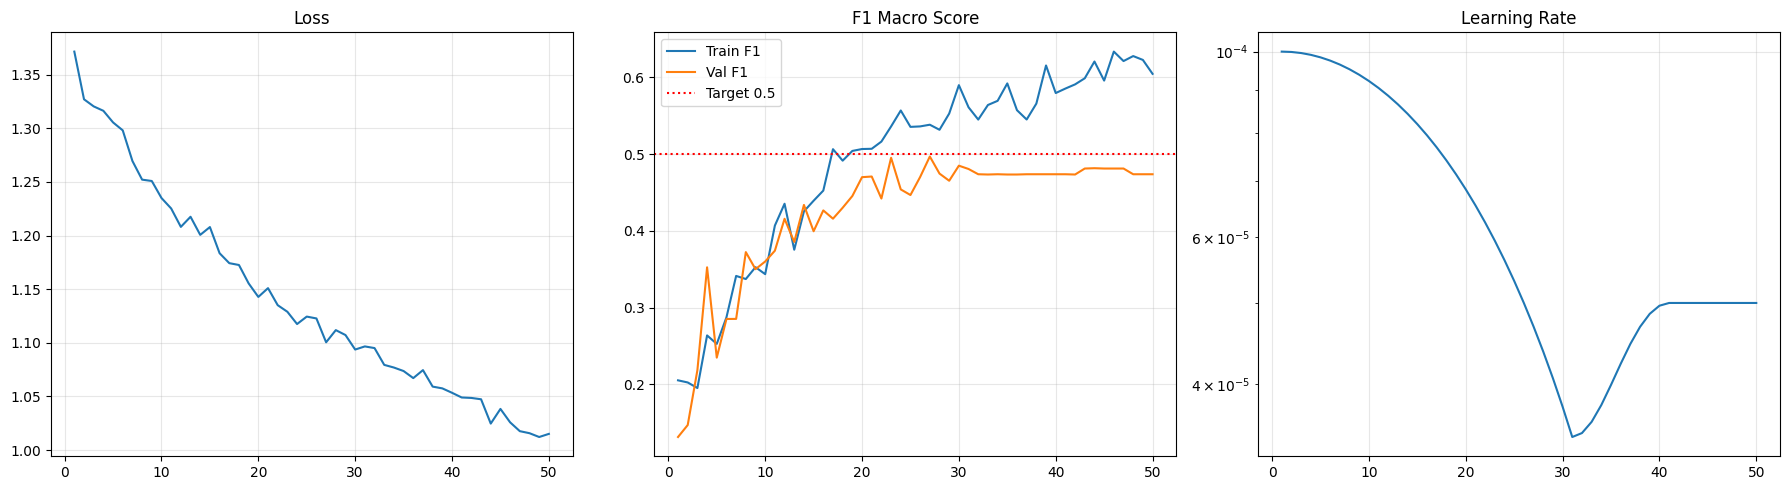


Generazione Matrice di Confusione sul Validation Set...
                 precision    recall  f1-score   support

        HER2(+)       0.45      0.50      0.47        26
      Luminal A       0.63      0.52      0.57        33
      Luminal B       0.55      0.70      0.62        40
Triple negative       0.60      0.23      0.33        13

       accuracy                           0.54       112
      macro avg       0.56      0.49      0.50       112
   weighted avg       0.56      0.54      0.54       112



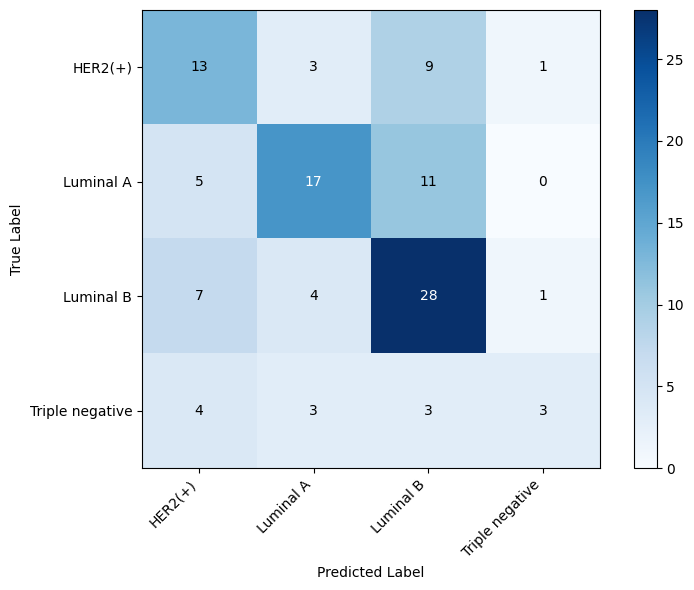

In [ ]:
# ==================================================================================
# PLOT RESULTS & CONFUSION MATRIX (MIL VERSION)
# ==================================================================================

# 1. PLOT CURVES
ep_range = range(1, len(hist['loss']) + 1)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Loss
ax[0].plot(ep_range, hist['loss'], label='Train Loss')
ax[0].set_title("Loss")
ax[0].grid(True, alpha=0.3)

# F1 Score
ax[1].plot(ep_range, hist['train_f1'], label='Train F1')
ax[1].plot(ep_range, hist['val_f1'], label='Val F1')
ax[1].axhline(0.5, color='r', linestyle=':', label='Target 0.5')
ax[1].set_title("F1 Macro Score")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# LR
ax[2].plot(ep_range, hist['lr'])
ax[2].set_title("Learning Rate")
ax[2].set_yscale('log')
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. CONFUSION MATRIX ON VALIDATION
print("\nGenerating Confusion Matrix on Validation Set...")

# Reload the correct model (GatedAttentionMIL)
best_model = GatedAttentionMIL(d_in=EMB_DIM, nc=NUM_CLASSES).to(device)
best_model.load_state_dict(torch.load(CKPT_PATH))
best_model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for bags, labels, _ in val_loader:
        bags = bags.to(device)
        logits, _ = best_model(bags)
        y_pred.append(torch.argmax(logits, dim=1).cpu().item())
        y_true.append(labels.item())

# Report
print(classification_report(y_true, y_pred, target_names=unique_labels))

# Matrix Plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

# Labels
tick_marks = np.arange(len(unique_labels))
plt.xticks(tick_marks, unique_labels, rotation=45, ha='right')
plt.yticks(tick_marks, unique_labels)

# Text values
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# TEST FILES
all_f = [f for f in os.listdir(TEST_IMAGES_ROOT) if os.path.isfile(os.path.join(TEST_IMAGES_ROOT,f))]
pat = re.compile(r"^(.*)\s(\d+)(\.\w+)$")
kept = [f for f in all_f if not (pat.match(f) and pat.match(f).group(1)+pat.match(f).group(3) in set(all_f))]
test_files = sorted(set(kept))
print(f"Test: {len(test_files)}")
test_df = pd.DataFrame({IMG_COL: test_files})

Test: 477


In [ ]:
# TEST EMBEDDINGS
test_df2, test_coords = build_patch_index(test_df, TEST_IMAGES_ROOT, IMG_COL, PATCH_SIZE, PATCH_STRIDE, DROP_LAST_PATCH, USE_BLACK_FILTER, TOPK_IF_TOO_MANY, True)
num_test = len(test_df2)
if not os.path.isfile(TEST_EMB_PATH): extract_and_cache(test_df2, test_coords, TEST_IMAGES_ROOT, TEST_EMB_PATH, False)
else: print("Cached:", TEST_EMB_PATH)

[build_patch_index] images: 477 | patches kept: 11430
[build_patch_index] dropped: 30765/59238 (51.9%)


Extract -> test_emb_v4.npz:   0%|          | 0/477 [00:00<?, ?it/s]

Saved: /kaggle/working/test_emb_v4.npz | (11430, 384)


In [ ]:
# ==================================================================================
# SUBMISSION / INFERENCE (MIL VERSION FIX)
# ==================================================================================
from tqdm.auto import tqdm

# 1. SETUP TEST DATA (If not already done)
if 'X_test' not in locals():
    print(f"Loading Test Embeddings from: {TEST_EMB_PATH}")
    test_npz = np.load(TEST_EMB_PATH, allow_pickle=True)
    X_test = test_npz["feats"].astype(np.float32)
    id_test = test_npz["img_ids"].astype(np.int64)
    y_test_dummy = np.zeros(len(X_test), dtype=np.int64)
    num_test_images = len(test_df2)
    
    print("Creating Test Bags...")
    test_bags, _, test_bag_ids = create_bags(X_test, y_test_dummy, id_test, num_test_images)
    test_ds_bag = BagDataset(test_bags, np.zeros(len(test_bags)), test_bag_ids)
    test_loader = DataLoader(test_ds_bag, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

# 2. LOAD THE CORRECT MODEL
# IMPORTANT: Instantiate the MIL class, not the old Head
model = GatedAttentionMIL(d_in=EMB_DIM, nc=NUM_CLASSES).to(device)

try:
    model.load_state_dict(torch.load(CKPT_PATH))
    print(f"✓ Weights loaded correctly from {CKPT_PATH}")
except RuntimeError as e:
    print(f"Error loading standard weights. Trying SWA...")
    try:
        model.load_state_dict(torch.load(SWA_CKPT_PATH))
        print(f"✓ SWA weights loaded correctly")
    except:
        print("CRITICAL ERROR: Unable to load weights. Make sure MIL training is finished.")
        raise e

model.eval()

# 3. PREDICTION
predictions = []
img_indices = []

print("Starting inference...")
with torch.no_grad():
    for bags, _, bag_ids in tqdm(test_loader, desc="Inference"):
        bags = bags.to(device)
        logits, _ = model(bags)
        pred_cls = torch.argmax(logits, dim=1).cpu().item()
        predictions.append(pred_cls)
        img_indices.append(bag_ids.item())

# 4. SAVE CSV
final_filenames = test_df2.iloc[img_indices][IMG_COL].tolist()
final_labels_text = [id2label[i] for i in predictions]

sub = pd.DataFrame({
    IMG_COL: final_filenames,
    LABEL_COL: final_labels_text
})
sub = sub.sort_values(IMG_COL).reset_index(drop=True)
sub.to_csv(SUBMISSION_PATH, index=False)

print(f"Saved submission to: {SUBMISSION_PATH}")
print("Predicted class distribution:")
print(sub[LABEL_COL].value_counts())
sub.head()

✓ Pesi caricati correttamente da /kaggle/working/best_head.pth
Avvio inferenza...


Inference:   0%|          | 0/477 [00:00<?, ?it/s]

Saved submission to: /kaggle/working/submission.csv
Distribuzione classi predette:
label
Luminal B          211
Luminal A          128
HER2(+)            115
Triple negative     23
Name: count, dtype: int64


sample_index      label
0  img_0000.png  Luminal A
1  img_0001.png  Luminal A
2  img_0002.png  Luminal B
3  img_0003.png  Luminal B
4  img_0004.png  Luminal A